# ASAP: A Dynamic & Proactive Approach for **A**ndroid **S**ecurity **A**nalysis and **P**rivacy

In [1]:
%matplotlib inline
import gzip
import time
import textwrap
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, matthews_corrcoef, f1_score
from imblearn.under_sampling import RandomUnderSampler

import keras
from tqdm.keras import TqdmCallback


#plt.style.use('seaborn-v0_8-paper')
plt.style.use('tableau-colorblind10')
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['lines.linewidth'] = 2


# Color Blind adjusted colors and markers
colormap=['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
markers=['o', '*', '.', 'x', '+', 's', 'd', 'h', 'v']
lines=['-', ':', '--', '-.']

## Load and clean the datasets

In [2]:
df_exodus = pl.read_csv('../datasets/exodus.csv.gz')
df_exodus = df_exodus.rename({col: col.lower() for col in df_exodus.columns})
df_exodus = df_exodus.rename({'class': 'label'})
if 'package' in df_exodus.columns: # deal with null values
    df_exodus = df_exodus.filter(pl.col('package').is_not_null())

df_exodus_clean = df_exodus.drop(['package']) # Add to remove several columns here
df_exodus_clean = df_exodus_clean.with_columns(pl.all().cast(pl.Float32))
print(df_exodus_clean.shape)
print(df_exodus_clean.dtypes)

(29999, 204)
[Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float

In [3]:
df_apd = pl.read_csv('../datasets/android_permission_dataset.csv.gz')
df_apd = df_apd.rename({col: col.lower() for col in df_apd.columns})
df_apd = df_apd.rename({'class': 'label'})
if 'package' in df_apd.columns: # deal with null values
    df_apd = df_apd.filter(pl.col('package').is_not_null())

df_apd_clean = df_apd.drop(['name']) # Add to remove several columns here
df_apd_clean = df_apd_clean.with_columns(pl.all().cast(pl.Float32))
print(df_apd_clean.shape)
print(df_apd_clean.dtypes)

(83698, 122)
[Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float

In [4]:
df_abig = pl.read_csv('../datasets/android_big.csv.gz')
df_abig = df_abig.rename({col: col.lower() for col in df_apd.columns})
df_abig = df_abig.rename({'class': 'label'})
if 'package' in df_abig.columns: # deal with null values
    df_abig = df_abig.filter(pl.col('package').is_not_null())

df_abig_clean = df_abig.drop(['package'])
df_abig_clean = df_abig_clean.with_columns(pl.all().cast(pl.Float32))
print(df_abig_clean.shape)
print(df_abig_clean.dtypes)

(1795204, 74)
[Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32]


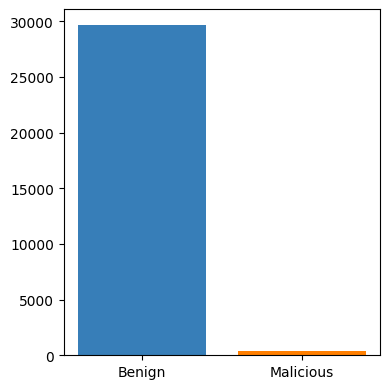

Percentage of Malicious Applications: 1.3%


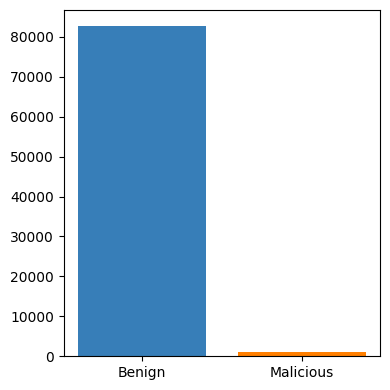

Percentage of Malicious Applications: 1.3%


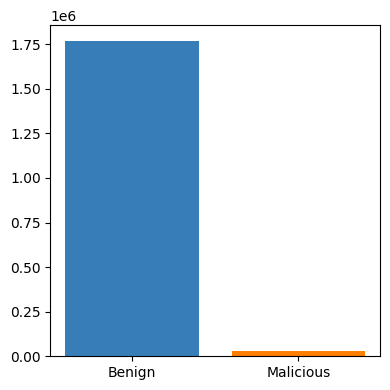

Percentage of Malicious Applications: 1.5%


In [5]:
dfs_clean = [df_exodus_clean, df_apd_clean, df_abig_clean]

for df_clean, name in zip(dfs_clean, ['exodus', 'apd', 'abig']):
    df_malicious = df_clean.filter(pl.col('label') == 1)
    df_benign    = df_clean.filter(pl.col('label') == 0)
    
    plt.bar(['Benign'], [df_benign.shape[0]], color = colormap[0], width = 0.8)
    plt.bar(['Malicious'], [df_malicious.shape[0]], color = colormap[1], width = 0.8)
    
    plt.show()
    print(f'Percentage of Malicious Applications: {len(df_malicious)/(len(df_malicious) + len(df_benign)):.1%}')

In [6]:
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width, break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

## Logistic Regression (Reference Model)

MCC: 0.414179431643358 F1-Score 0.47368421052631576


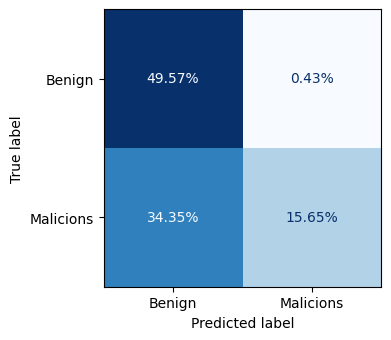

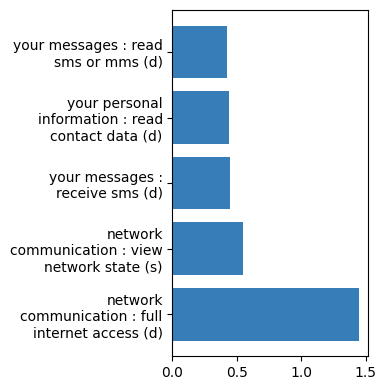

MCC: 0.6235518647906875 F1-Score 0.7210626185958254


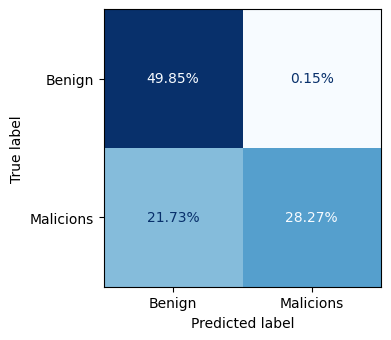

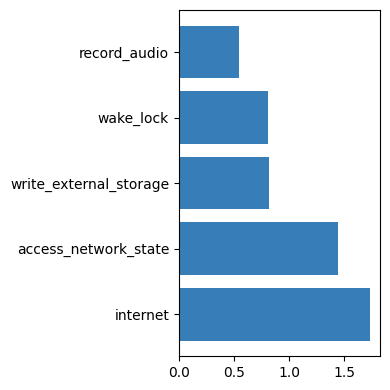

MCC: 0.0 F1-Score 0.0


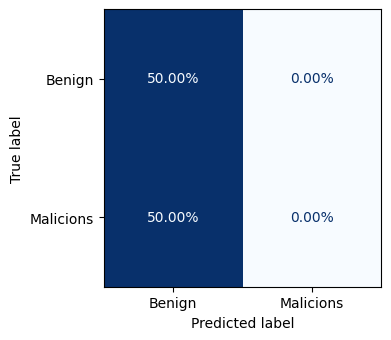

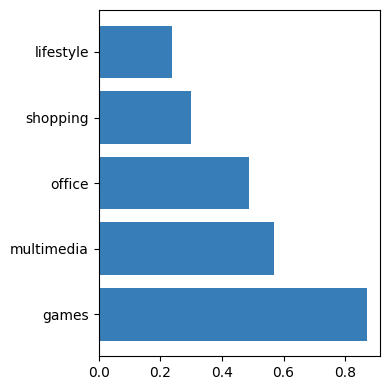

In [7]:
for df_clean, name in zip(dfs_clean, ['exodus', 'apd', 'abig']):
    undersample = RandomUnderSampler(sampling_strategy='majority')
    Y = df_clean['label']
    X = df_clean.drop(['label'])

    X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), Y.to_numpy(), 
    test_size=0.3, random_state=42, stratify=Y)
    X_test, y_test = undersample.fit_resample(X_test, y_test)

    clf = LogisticRegression(random_state=42, solver='lbfgs', max_iter=100, penalty=None, tol=1E-2)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'MCC: {mcc} F1-Score {f1}')

    cf_matrix = confusion_matrix(y_test, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix/np.sum(cf_matrix),
    display_labels = ['Benign', 'Malicions'])
    cm_display.plot(values_format='.2%', colorbar=False, cmap='Blues')
    plt.show() 

    weights = clf.coef_[0]
    abs_weights = np.abs(weights)
    features = np.array(X.columns)
    sorted_index = np.argsort(abs_weights)[::-1]
    top_high_k = sorted_index[:5]

    labels = features[top_high_k]
    labels = [textwrap.fill(l, width=20, break_long_words=False) for l in labels]
   
    plt.barh(y=labels, width=abs_weights[top_high_k], color = colormap[0])
    plt.show()

## Decision Tree (Reference Model)

MCC: 0.8017837257372732 F1-Score 0.8780487804878049


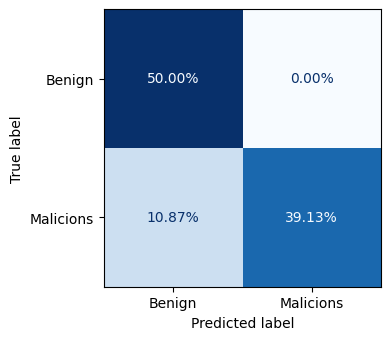

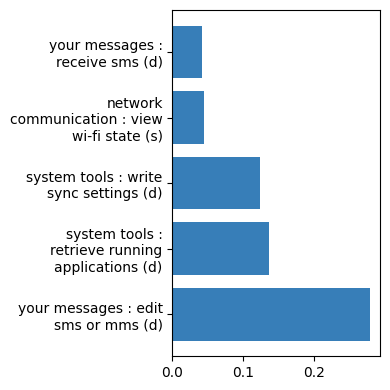

MCC: 0.7439938248768801 F1-Score 0.8339100346020761


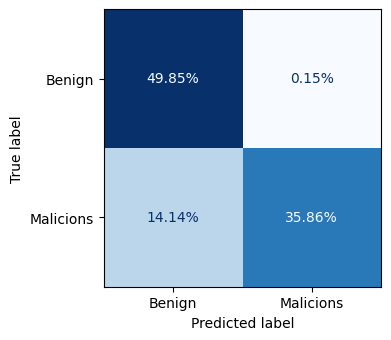

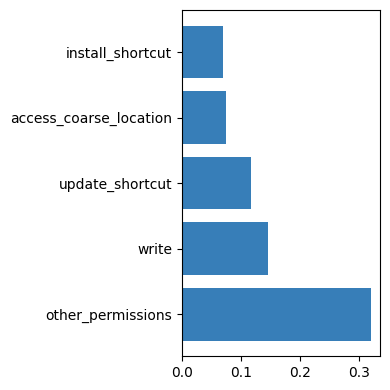

MCC: 0.7191236861534981 F1-Score 0.8107478336852836


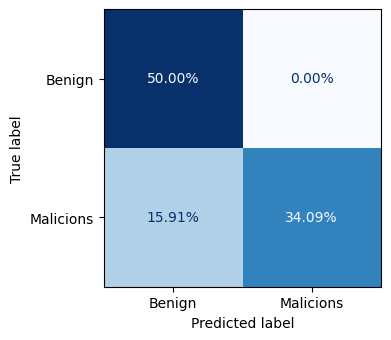

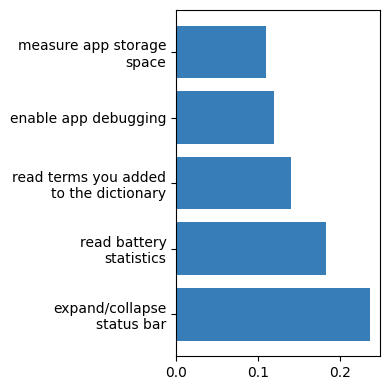

In [8]:
for df_clean, name in zip(dfs_clean, ['exodus', 'apd', 'abig']):
    undersample = RandomUnderSampler(sampling_strategy='majority')
    Y = df_clean['label']
    X = df_clean.drop(['label'])

    X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), Y.to_numpy(), 
    test_size=0.3, random_state=42, stratify=Y)
    X_test, y_test = undersample.fit_resample(X_test, y_test)

    clf = DecisionTreeClassifier(random_state=42, max_depth=8)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'MCC: {mcc} F1-Score {f1}')

    cf_matrix = confusion_matrix(y_test, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix/np.sum(cf_matrix),
    display_labels = ['Benign', 'Malicions'])
    cm_display.plot(values_format='.2%', colorbar=False, cmap='Blues')
    plt.show() 

    # Feature importance
    weights = clf.feature_importances_
    abs_weights = np.abs(weights)
    features = np.array(X.columns)
    sorted_index = np.argsort(abs_weights)[::-1]
    top_high_k = sorted_index[:5]
    #top_low_k = sorted_index[-5:]

    labels = features[top_high_k]
    labels = [textwrap.fill(l, width=20, break_long_words=False) for l in labels]
   
    plt.barh(y=labels, width=abs_weights[top_high_k], color = colormap[0])
    plt.show()

## AutoEncoder Model


In [9]:
def isodata(array: np.ndarray) -> float:
    """
    Returns optimal threshold for dividing the sequence of values.

    Args:
        array (np.ndarray): numpy array with the values
    
    Returns:
        float: optimal threshold for dividing the sequence of values
    """
    median = np.median(array)
    previous_median = 0.0 
    
    while median != previous_median:
        median_left = np.median(array[array <= median])
        median_right = np.median(array[array > median])

        previous_median = median
        median = (median_left+median_right) / 2.0

    return median

def mad_score(points):
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    return 0.6745 * ad / mad

In [10]:
def autoencoder_model(input_dim, latent_dim, loss=keras.losses.Huber(delta=0.1), seed=42):
    keras.utils.set_random_seed(seed)

    inputlayer = keras.layers.Input(shape = (input_dim, ))
    encoder_00 = keras.layers.Dense(64, kernel_initializer='glorot_uniform', activation='silu')(inputlayer)
    encoder_01 = keras.layers.Dense(32, kernel_initializer='glorot_uniform', activation='silu')(encoder_00)

    latent = keras.layers.Dense(latent_dim, kernel_initializer='glorot_uniform', activation='silu')(encoder_01)

    decoder_00 = keras.layers.Dense(32, kernel_initializer='glorot_uniform', activation='silu')(latent)
    decoder_01 = keras.layers.Dense(64, kernel_initializer='glorot_uniform', activation='silu')(decoder_00)
    outputlayer = keras.layers.Dense(input_dim, kernel_initializer='glorot_uniform', activation='linear')(decoder_01)

    autoencoder = keras.Model(inputs = inputlayer, outputs = outputlayer)
    autoencoder.compile(optimizer=keras.optimizers.Adam(), loss=loss, metrics=['r2_score'])
    
    return autoencoder

In [11]:
def sparse_autoencoder_model(input_dim, latent_dim, loss=keras.losses.Huber(delta=0.1), l1=0.01, seed=42):
    keras.utils.set_random_seed(seed)

    inputlayer = keras.layers.Input(shape = (input_dim, ))
    encoder_00 = keras.layers.Dense(64, kernel_initializer='glorot_uniform', 
    activation='silu', kernel_regularizer=keras.regularizers.L1(l1)
    )(inputlayer)
    encoder_01 = keras.layers.Dense(32, kernel_initializer='glorot_uniform',
    activation='silu', kernel_regularizer=keras.regularizers.L1(l1)
    )(encoder_00)

    latent = keras.layers.Dense(latent_dim, kernel_initializer='glorot_uniform',
    activation='silu', kernel_regularizer=keras.regularizers.L1(l1))(encoder_01)

    decoder_00 = keras.layers.Dense(32, kernel_initializer='glorot_uniform', activation='silu')(latent)
    decoder_01 = keras.layers.Dense(64, kernel_initializer='glorot_uniform', activation='silu')(decoder_00)
    outputlayer = keras.layers.Dense(input_dim, kernel_initializer='glorot_uniform', activation='linear')(decoder_01)

    autoencoder = keras.Model(inputs = inputlayer, outputs = outputlayer)
    autoencoder.compile(optimizer=keras.optimizers.Adam(), loss=loss, metrics=['r2_score'])
    
    return autoencoder

float32
Training data 26999 Testing data 76


0epoch [00:00, ?epoch/s]

(exodus ae) Training time 3.42 seconds


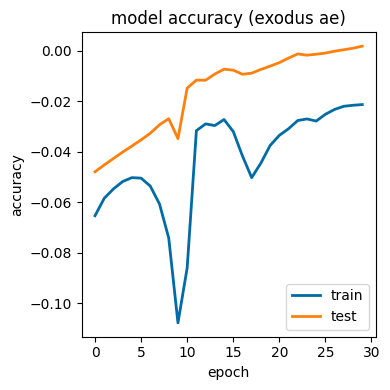

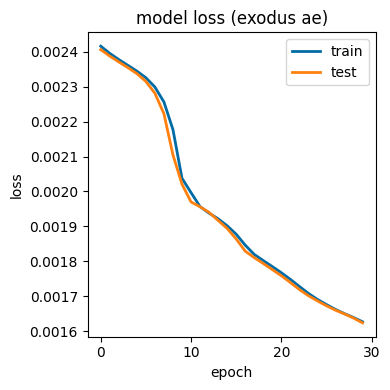

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
0.5% anomaly


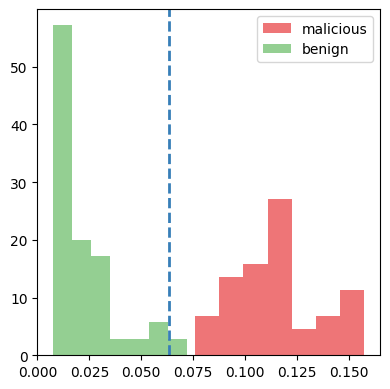

(exodus ae) MCC: 0.9740215340114143 F1-Score 0.987012987012987


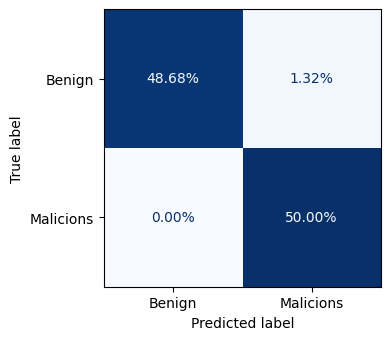

0epoch [00:00, ?epoch/s]

(exodus sae) Training time 3.49 seconds


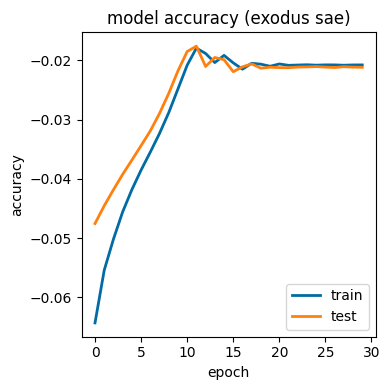

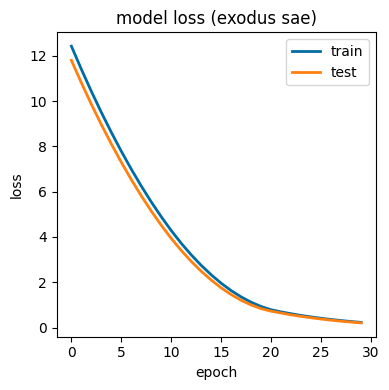

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.5% anomaly


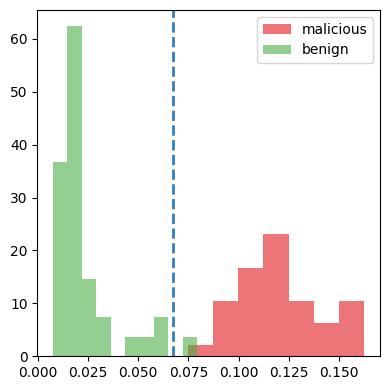

(exodus sae) MCC: 0.9740215340114143 F1-Score 0.987012987012987


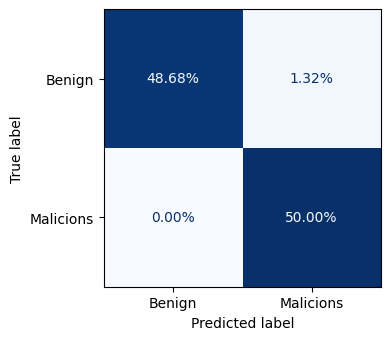

float32
Training data 75328 Testing data 224


0epoch [00:00, ?epoch/s]

(apd ae) Training time 5.00 seconds


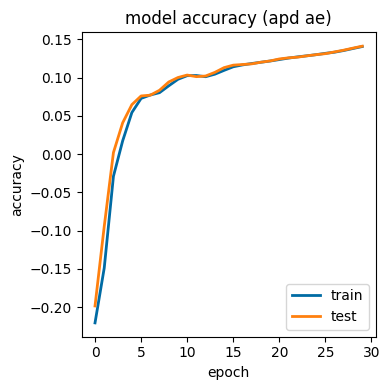

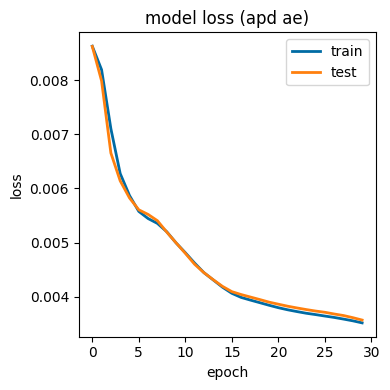

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
0.5% anomaly


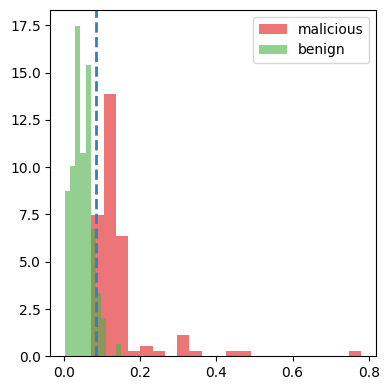

(apd ae) MCC: 0.8751395423021391 F1-Score 0.9380530973451328


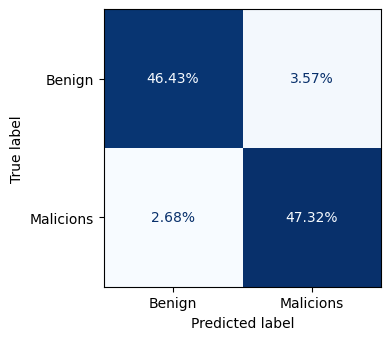

0epoch [00:00, ?epoch/s]

(apd sae) Training time 5.20 seconds


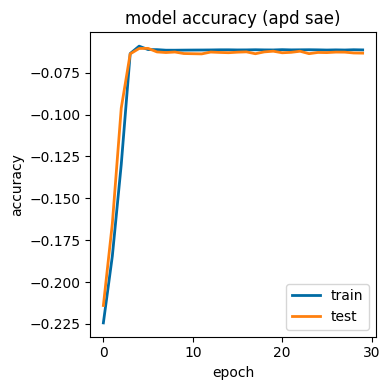

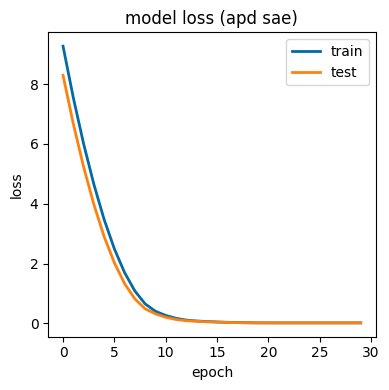

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
0.5% anomaly


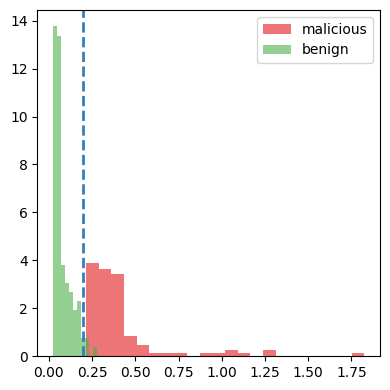

(apd sae) MCC: 0.9563105743062316 F1-Score 0.9781659388646288


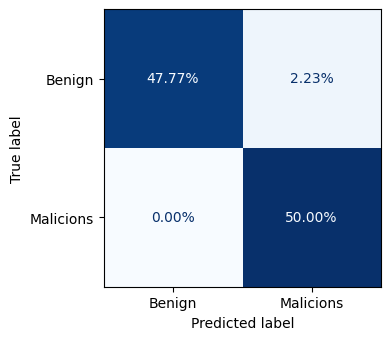

float32
Training data 1615683 Testing data 5444


0epoch [00:00, ?epoch/s]

(abig ae) Training time 20.18 seconds


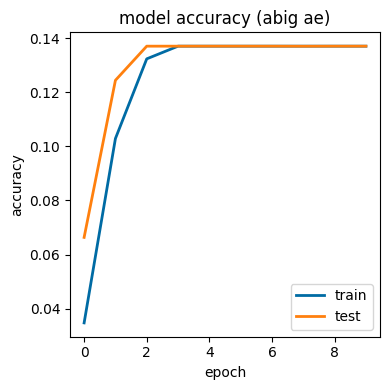

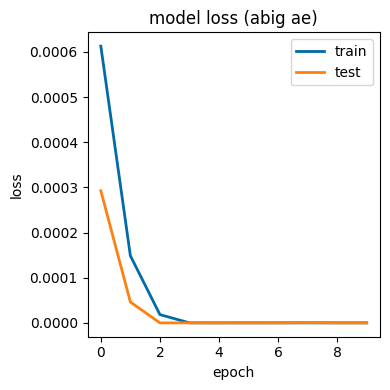

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
0.5% anomaly


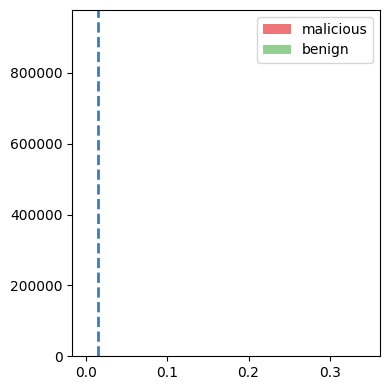

(abig ae) MCC: 1.0 F1-Score 1.0


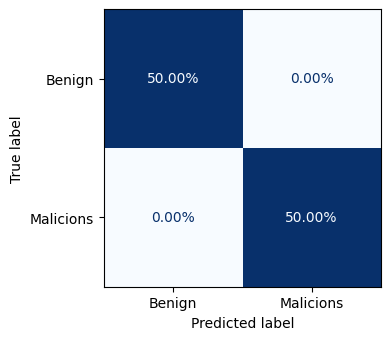

0epoch [00:00, ?epoch/s]

(abig sae) Training time 38.10 seconds


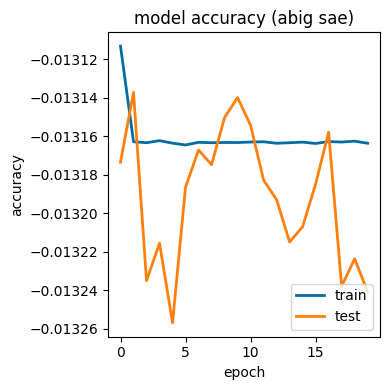

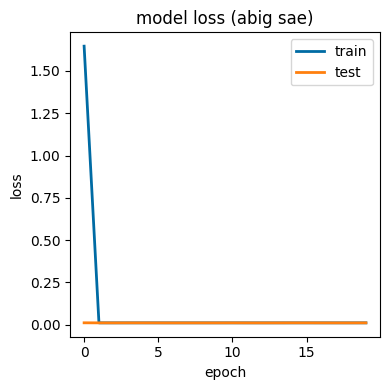

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step
0.5% anomaly


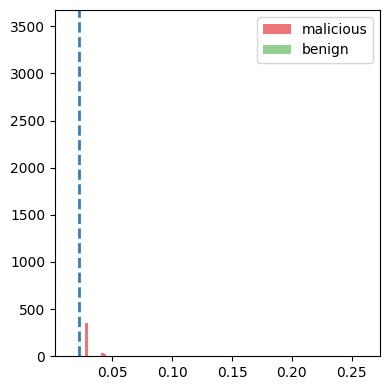

(abig sae) MCC: 1.0 F1-Score 1.0


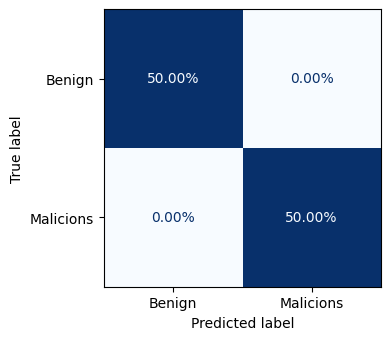

In [12]:
for df_clean, name in zip(dfs_clean, ['exodus', 'apd', 'abig']):
    undersample = RandomUnderSampler(sampling_strategy='majority')
    Y = df_clean['label']
    X = df_clean.drop(['label'])

    X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), Y.to_numpy(), 
    test_size=0.1, random_state=42, stratify=Y)
    
    # Need to remove malicions samples
    X_train = X_train[y_train == 0]
    X_validation = X_test[y_test == 0]

    print(X_train.dtype)

    # undersample the Test part
    X_test, y_test = undersample.fit_resample(X_test, y_test)

    print(f'Training data {len(y_train)} Testing data {(len(y_test))}')
    
    # data dimensions // hyperparameters 
    input_dim = X_train.shape[-1]
    latent_dim = 8

    models = [('ae',autoencoder_model(input_dim, latent_dim)),
    ('sae', sparse_autoencoder_model(input_dim, latent_dim))]
    
    for ae_name, autoencoder in models:
        #autoencoder.summary()

        # fix seed
        keras.utils.set_random_seed(42)

        start = time.perf_counter()
        EPOCHS = 30
        BATCH_SIZE = 4096
        history = autoencoder.fit(X_train, X_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
        validation_data=(X_validation, X_validation), verbose=0, 
        callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True),
        TqdmCallback(verbose=0)])
        stop = time.perf_counter()
        elapse_time = stop-start

        print(f'({name} {ae_name}) Training time {elapse_time:.2f} seconds')

        # summarize history for accuracy
        plt.plot(history.history['r2_score'])
        plt.plot(history.history['val_r2_score'])
        plt.title(f'model accuracy ({name} {ae_name})')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'model loss ({name} {ae_name})')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()

        reconstructions = autoencoder.predict(X_test)
        mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)
        mae = np.mean(np.abs(X_test - reconstructions), axis=1)

        malicious = mae[y_test==1]
        benign    = mae[y_test==0]

        print(f'{len(malicious)/(len(benign)+len(malicious)):.2}% anomaly')

        thr = isodata(mae)
        #print(f'({name} {ae_name}) ISO-Data Thr: {thr}')
        y_pred = mae > thr

        bin_edges_malicious = np.histogram_bin_edges(malicious, bins='auto')
        bin_edges_benign = np.histogram_bin_edges(benign, bins='auto')

        #print(f'({bin_edges_malicious}) {malicious}')
        #print(f'({bin_edges_benign}) {benign}')

        #fig, ax = plt.subplots(figsize=(6,6))
        ax = plt.gca()
        ax.hist(malicious, bins=bin_edges_malicious, density=True, label="malicious", alpha=.6, color=colormap[7])
        ax.hist(benign, bins=bin_edges_benign, density=True, label="benign", alpha=.6, color=colormap[2])
        plt.axvline(x = thr, color = colormap[0], linestyle='--')
        #print(f'{bin_edges_malicious}/{bin_edges_benign}')
        #plt.title("(Normalized) Distribution of the Reconstruction Error")
        plt.legend()
        plt.show()

        mcc = matthews_corrcoef(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        print(f'({name} {ae_name}) MCC: {mcc} F1-Score {f1}')

        cf_matrix = confusion_matrix(y_test, y_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix/np.sum(cf_matrix),
        display_labels = ['Benign', 'Malicions'])
        cm_display.plot(values_format='.2%', colorbar=False, cmap='Blues')
        plt.show()